In [1]:
#Import necessary libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
import optax

In [2]:
#OOP Implementation of Shampoo Optimizer
class Shampoo:

    #Initialize class with learning rate, shape of gradrient matrix and epsilon which is given
    #in the algorithm
    def __init__(self, lr=0.1, gshape=(2,2), epsilon=1e-5):

        self.epsilon = epsilon
        self.lr = lr
        self.gshape = gshape

        #define shapes of L and R preconditioning matrices
        self.lshape = (gshape[0], gshape[0])
        self.rshape = (gshape[1], gshape[1])

        #define L and R preconditioning matrices according to algorithm from the paper
        self.L = epsilon * jnp.eye(gshape[0])
        self.R = epsilon * jnp.eye(gshape[1])

    #This method calculates the -1/4 power of a matrix as it is used in the algorithm
    #It is done by diagonalizing the symmetric matrix (L, R are symmetric) and simply taking
    #the -1/4 power of the diagonal elements which are the eigenvalues.
    def power_minus14(self, mat):
        eigvals, eigvecs = jnp.linalg.eigh(mat)
        return eigvecs @ jnp.diag(eigvals**(-0.25)) @ eigvecs.T

    #This method updates L and R according to the algorithm
    def update_lr(self, G):
        #Update L, R
        G = G.reshape(self.gshape)
        self.L += (G @ G.T).reshape(self.lshape)
        self.R += (G.T @ G).reshape(self.rshape) 

    #This method completes a full iteration of the algorithm going from the existing weight
    #vector to a new updated weight vector
    #steps taken are according to the algorithm, reshaping is done at ties for matrix multiplication
    def step(self, W, grad_fn):

        #find gradient at current point
        G = grad_fn(W).reshape(self.gshape)

        #update preconditioners L and R
        self.update_lr(G)

        #calculate -1/4 power of the updated preconditioners
        new_L = self.power_minus14(self.L).reshape(self.lshape)
        new_R = self.power_minus14(self.R).reshape(self.rshape)

        #calculate the new preconditioned gradient matrix
        G_preconditioned = new_L @ G @ new_R

        #Update the weight vector
        return (W.reshape(self.gshape) - self.lr * G_preconditioned).reshape(-1)

In [3]:
#For optimization using the remaining 3 optimizers (SGD, ADAM, RMSProp), we define
#a function that performs optimization so that it can be reused for the 3 optimizers
#makes use of the Optax Library which has prebuilt functions for the 3 optimizers
def optaxer(optimizer, x_init, grad_fn, iterations):
    
    #Initialize optimizer with initial point
    W = x_init
    state = optimizer.init(W)

    #Lists to store losses, times and weights
    losses = []
    times = []
    w_vals = []

    #Run the optimizer for the defined number of iterations
    for i in range(iterations):
        start_time = time.time()

        #Update weight
        grads = grad_fn(W)
        updates, state = optimizer.update(grads, state)
        W = optax.apply_updates(W, updates)
        loss = loss_fn(W)
        end_time = time.time()

        #Save loss and time
        losses.append(loss)
        times.append(end_time - start_time)
        w_vals.append(W)

    return losses, times

In [4]:
#Task 1: Simple Quadratic Loss Function
def loss_fn(x): 
    return x[0]**2 + x[1]**2

#Gradient
grad_fn = jax.grad(loss_fn)

#Starting point
x_init = jnp.array([2.0, 2.0])

#Create an instance of the Shampoo class
shampoo = Shampoo(lr=1, gshape=(2,1))

#lists to store loss and weights
shampoo_losses = []
shampoo_times = []
w_vals = []
iterations = 40

#Run the algorithm for the set number of iterations, saving loss and weights and time along the way
W = x_init
for i in range(iterations):
    w_vals.append(W)
    start_time = time.time()
    loss = loss_fn(W)
    W = shampoo.step(W, grad_fn)
    end_time = time.time()
    shampoo_losses.append(loss)
    shampoo_times.append(end_time-start_time)

#Do Task 1 with SGD, ADAM and RMSProp
sgd = optax.sgd(learning_rate=0.1)
adam = optax.adam(learning_rate=0.1)
rmsprop = optax.rmsprop(learning_rate=0.1)

#Optimize the Loss using each optimizer
sgd_losses, sgd_times = optaxer(sgd, x_init, grad_fn, iterations)
adam_losses, adam_times = optaxer(adam, x_init, grad_fn, iterations)
rmsprop_losses, rmsprop_times = optaxer(rmsprop, x_init, grad_fn, iterations)

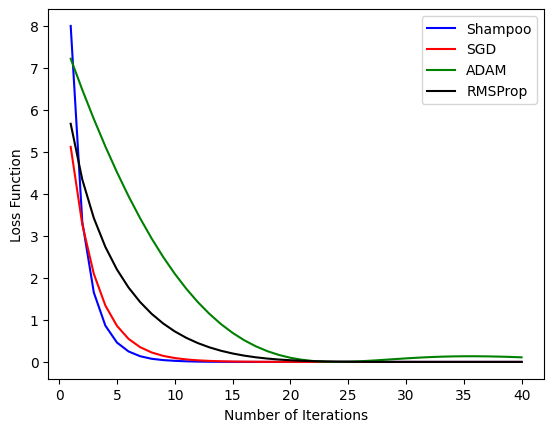

In [5]:
#Plotting Loss Function vs Number of Iterations
plt.plot(range(1,41), shampoo_losses, color='blue', label='Shampoo')
plt.plot(range(1,41), sgd_losses, color='red', label='SGD')
plt.plot(range(1,41), adam_losses, color='green', label='ADAM')
plt.plot(range(1,41), rmsprop_losses, color='black', label='RMSProp')
plt.ylabel('Loss Function')
plt.xlabel('Number of Iterations')
plt.legend()
plt.show()

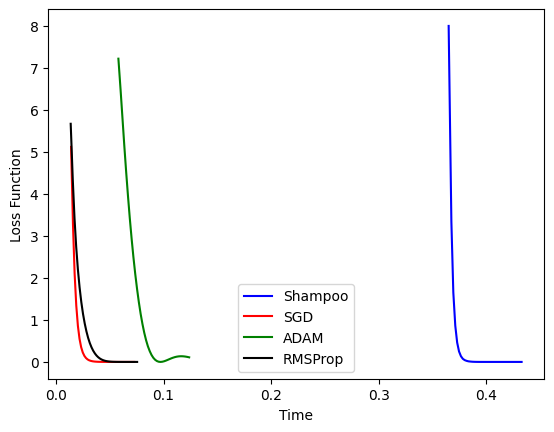

In [6]:
#Plotting Loss Function vs Time taken
plt.plot(jnp.cumsum(jnp.array(shampoo_times)), shampoo_losses, color='blue', label='Shampoo')
plt.plot(jnp.cumsum(jnp.array(sgd_times)), sgd_losses, color='red', label='SGD')
plt.plot(jnp.cumsum(jnp.array(adam_times)), adam_losses, color='green', label='ADAM')
plt.plot(jnp.cumsum(jnp.array(rmsprop_times)), rmsprop_losses, color='black', label='RMSProp')
plt.ylabel('Loss Function')
plt.xlabel('Time')
plt.legend()
plt.show()

In [7]:
#Task 2: The Rosenbrock Function
def loss_fn(x): 
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
    
#Gradient
grad_fn = jax.grad(loss_fn)

#Starting Point
x_init = jnp.array([1.5, 1.5])

#Create an instance of the Shampoo class
shampoo = Shampoo(lr=0.7, gshape=(2,1), epsilon=1e-2)

#Lists to store loss and weights
shampoo_losses = []
shampoo_times = []
w_vals = []
iterations = 1200

#Run the algorithm for the set number of iterations, saving loss and weights and time along the way
W = x_init
for i in range(iterations):
    w_vals.append(W)
    start_time = time.time()
    loss = loss_fn(W)
    W = shampoo.step(W, grad_fn)
    end_time = time.time()
    shampoo_losses.append(loss)
    shampoo_times.append(end_time-start_time)

#Do Task 2 with SGD, ADAM, RMSProp
sgd = optax.sgd(learning_rate=0.001)
adam = optax.adam(learning_rate=0.01)
rmsprop = optax.rmsprop(learning_rate=0.001)

#Optimize the Loss using each optimizer
sgd_losses, sgd_times = optaxer(sgd, x_init, grad_fn, iterations)
adam_losses, adam_times = optaxer(adam, x_init, grad_fn, iterations)
rmsprop_losses, rmsprop_times = optaxer(rmsprop, x_init, grad_fn, iterations)

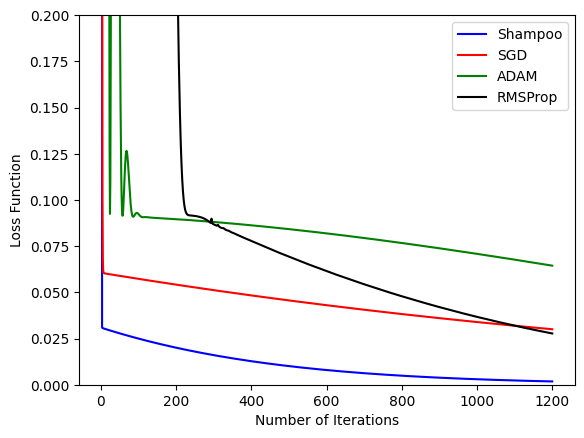

In [8]:
#Plotting Loss Function vs Number of Iterations
plt.plot(range(1,1201), shampoo_losses, color='blue', label='Shampoo')
plt.plot(range(1,1201), sgd_losses, color='red', label='SGD')
plt.plot(range(1,1201), adam_losses, color='green', label='ADAM')
plt.plot(range(1,1201), rmsprop_losses, color='black', label='RMSProp')
plt.ylim(top=0.2, bottom=0)
plt.ylabel('Loss Function')
plt.xlabel('Number of Iterations')
plt.legend()
plt.show()

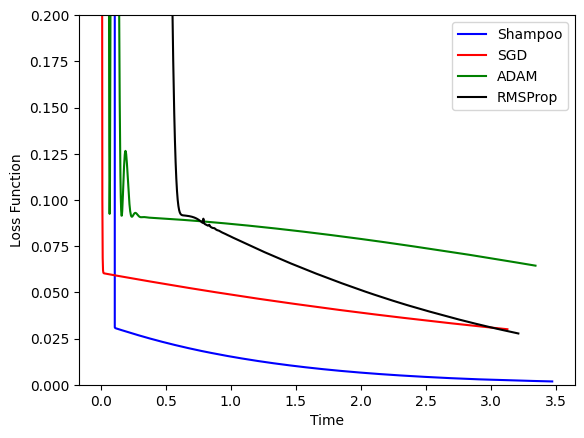

In [9]:
#Plotting Loss Function vs Time taken
plt.plot(jnp.cumsum(jnp.array(shampoo_times)), shampoo_losses, color='blue', label='Shampoo')
plt.plot(jnp.cumsum(jnp.array(sgd_times)), sgd_losses, color='red', label='SGD')
plt.plot(jnp.cumsum(jnp.array(adam_times)), adam_losses, color='green', label='ADAM')
plt.plot(jnp.cumsum(jnp.array(rmsprop_times)), rmsprop_losses, color='black', label='RMSProp')
plt.ylim(top=0.2, bottom=0)
plt.ylabel('Loss Function')
plt.xlabel('Time')
plt.legend()
plt.show()

In [10]:
#Task 3: Multiple Linear Regression
#Multiple linear regression with 2 independent variables
#Our model is Y = XB + epsilon, where B = [B_0,B_1,B_2], B_0 is intercept
#B_1 and B_2 are coefficients of X_1 and X_2

#Set a seed
np.random.seed(4212)

#Generate True Values of X_1 and X_2, B
X = np.random.rand(100, 2)
B = np.array([2,4,3])

#add column of 1s in X for the intercept term
X = np.hstack((np.array([1 for i in range(100)]).reshape(-1,1),X))

#Generate true Y
Y = X@B + np.random.randn(100)

In [11]:
#Loss function which is MSE
def loss_fn(B_hat):
    return jnp.mean((X@B_hat - Y) ** 2)

#Gradient
grad_fn = jax.grad(loss_fn)

#Starting point
B_init = jnp.array([0.0, 2.0, 2.0])

#Create an instance of the Shampoo class
shampoo = Shampoo(lr=0.3, gshape=(3,1), epsilon=1e-3)

#Lists to store loss and weights
shampoo_losses = []
shampoo_times = []
w_vals = []
iterations = 300

#Run the algorithm for the set number of iterations, saving loss and weights and time along the way
W = B_init
for i in range(iterations):
    w_vals.append(W)
    start_time = time.time()
    loss = loss_fn(W)
    W = shampoo.step(W, grad_fn)
    end_time = time.time()
    shampoo_losses.append(loss)
    shampoo_times.append(end_time-start_time)

#Do Task 3 with SGD, ADAM, RMSProp
sgd = optax.sgd(learning_rate=0.01)
adam = optax.adam(learning_rate=0.01)
rmsprop = optax.rmsprop(learning_rate=0.01)

#Optimize the Loss using each optimizer
sgd_losses, sgd_times = optaxer(sgd, B_init, grad_fn, iterations)
adam_losses, adam_times = optaxer(adam, B_init, grad_fn, iterations)
rmsprop_losses, rmsprop_times = optaxer(rmsprop, B_init, grad_fn, iterations)

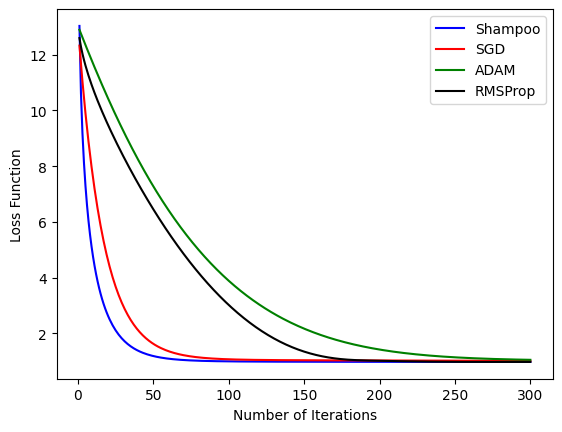

In [12]:
#Plotting Loss Function vs Number of Iterations
plt.plot(range(1,301), shampoo_losses, color='blue', label='Shampoo')
plt.plot(range(1,301), sgd_losses, color='red', label='SGD')
plt.plot(range(1,301), adam_losses, color='green', label='ADAM')
plt.plot(range(1,301), rmsprop_losses, color='black', label='RMSProp')
plt.ylabel('Loss Function')
plt.xlabel('Number of Iterations')
plt.legend()
plt.show()

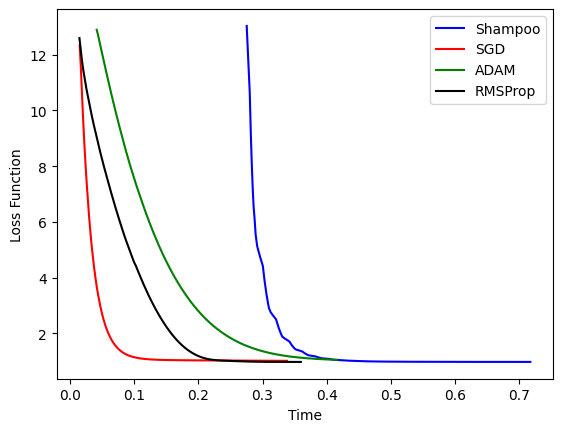

In [13]:
#Plotting Loss Function vs Time taken
plt.plot(jnp.cumsum(jnp.array(shampoo_times)), shampoo_losses, color='blue', label='Shampoo')
plt.plot(jnp.cumsum(jnp.array(sgd_times)), sgd_losses, color='red', label='SGD')
plt.plot(jnp.cumsum(jnp.array(adam_times)), adam_losses, color='green', label='ADAM')
plt.plot(jnp.cumsum(jnp.array(rmsprop_times)), rmsprop_losses, color='black', label='RMSProp')
plt.ylabel('Loss Function')
plt.xlabel('Time')
plt.legend()
plt.show()